In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg
from sympy import *
from tqdm import tqdm
from integrator_functions import euler_integrator_step, vel_verlet_integrator_step, leap_frog_integrator_step, acf
import scipy.special

font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

# Heavy particle in a heat bath

Considera heavy particle $\lbrace Q, \, P, \, M \rbrace$, where $Q$ denotes the position, $P$ the momentum and $M$ the mass, in contact with a heat bath consisting of $N$ coupled oscillators $\lbrace q_i, \, p_i, \, m_i \rbrace$.

The hamiltonian of the system is

\begin{equation}
H = \frac{P^2}{2M} + \sum_{i=1}^N \frac{p_i^2}{2m_i} + V(Q) + \frac{1}{2 }  \sum_{i=1}^N k_i \,  (q_i - Q)^2
\end{equation}

The equations of motion of the heavy particle are 

\begin{equation}
\begin{cases}
\dot{Q} &= \frac{P}{M} \\
\dot{P} &= -\nabla V(Q) - \sum_{i=1}^N k_i \, (Q - q_i)\\
\end{cases} \, .
\end{equation}

The equations of motion of the $N$ lights particles of the heat bath are 

\begin{equation}
\begin{cases}
\dot{q_i} &= \frac{p_i}{m_i} \\
\dot{p_i} &= k_i \, (Q - q_i)\\
\end{cases} \, .
\end{equation}

# Initial positions and momenta of the oscillators

We draw the initial positions and the initial momenta from the Boltzmann distributions:

$$
\pi_q (q_i) = \frac{1}{Z_q} \exp\left( - \beta \frac{k_i}{2}(q_i - Q(0))^2 \right) \,; \quad\quad \pi_p (p_i) = \frac{1}{Z_p} \exp\left( - \beta \frac{p_i^2}{2m_i}\right) \, .
$$

Comparing with the Gaussian function

$$
f(x) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left( -  \frac{1}{2}\frac{(x - x(0))^2}{\sigma^2} \right) \, ,
$$

we obtain that the initial positions and momenta can be estimated as

$$
q_i(0) = Q(0) + \xi_i \sqrt{\frac{1}{\beta k_i}} \\
p_i(0) = \eta_i \sqrt{\frac{m_i}{\beta}} \, ,
$$

with $\xi, \eta_i \in \mathcal{N}(0,1)$.

## Integrator setup, system parameters, position discretization

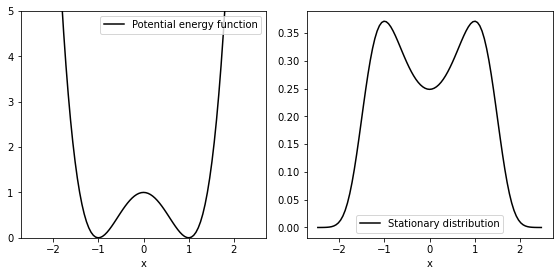

In [5]:
#integrator = 'Euler'
#integrator = 'velocity_verlet'
integrator = 'leap_frog'

# Number of timesteps
Nsteps = 4000000

# Integration timestep
dt = 0.02

x = symbols('x')

# System parameters
kB    = 0.008314463 # kJ mol-1 K
T     = 300         # K
beta  = 1 / kB / T  # kJ-1 mol
M     = 1           # amu

# Potential energy function kJ mol-1
V     = 1*(x**2 - 1)**2  
#V     = x**2

der_V = V.diff(x)
V     = lambdify((x), V, modules=['numpy'])
der_V = lambdify((x), der_V, modules=['numpy'])

# Q-Grid
xmin  = -2.5
xmax  = - xmin
xbins = 100
xedges = np.linspace(xmin,xmax,xbins)
dx = xedges[1] - xedges[0]
xcenters = xedges + 0.5* dx
xcenters = np.delete(xcenters,-1)
xbins = len(xcenters)

stat_distr = np.exp(-beta * V(xcenters)) / np.sum(np.exp(-beta * V(xcenters)) * dx)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20*in2cm, 10*in2cm))  

ax1.plot(xcenters, V(xcenters), 'k-',label='Potential energy function')
ax1.legend()
ax1.set_xlabel('x');
ax1.set_ylim((0,5))
ax2.plot(xcenters, stat_distr, 'k-',label='Stationary distribution')
ax2.set_xlabel('x');
ax2.legend()

fig.tight_layout()


# Initial frequencies, spring constants and masses of the oscillators

The $i$th particle, with mass $m_i$ and spring constant $k_i$, oscillates with frequency

$$
\omega_i = \sqrt{\frac{k_i}{m_i}} \, .
$$

The frequencies are drawn from a uniform distribution:

$$
\omega_i = N^a \nu_i\,; \quad \nu_i \in \mathcal{U}(0,1)\,; \quad a \in[0,1]
$$

The spring constants are written as

$$
k_i = f^2(\omega_i) \Delta \omega \, , 
$$

where 

$$
\Delta \omega = \frac{N^a}{N} \,,
$$

and

$$
f(\omega_i) = \sqrt{\frac{2}{\pi} \frac{1}{1 + \omega^2}} \, .
$$

In [3]:
# Number of oscillators
N     = 2000

#####################################################
############# case 1
#####################################################

omega1    = np.ones(N)
m1        = M * np.ones(N) / 100
k_spring1 = omega1**2 * m1



#####################################################
############# case 2
#####################################################



omega2    = np.linspace(1, 12.5, N)
m2        = M * np.ones(N) / 100
k_spring2 = omega2 **2 * m1


#####################################################
############# case 3
#####################################################



gamma   = 1
a      = 0.333333

deltaw = N**a / N

alpha   = 1
barbeta = (alpha * gamma)**-1

def f2(omega):
    return 2*alpha / (np.pi*barbeta) * 1 / ( alpha**2  + omega ** 2)


omega3    = np.random.uniform(0,1,N) * N ** a
k_spring3 = f2(omega3) * N**a / N
m3        = k_spring3 / omega3 ** 2

In [4]:
# Trajectoryes arrays
Q1 = np.zeros((Nsteps))
q1 = np.zeros(N)
P1 = np.zeros((Nsteps))
p1 = np.zeros(N)

Q2 = np.zeros((Nsteps))
q2 = np.zeros(N)
P2 = np.zeros((Nsteps))
p2 = np.zeros(N)

Q3 = np.zeros((Nsteps))
q3 = np.zeros(N)
P3 = np.zeros((Nsteps))
p3 = np.zeros(N)


# Initial position heavy particle
Q0    = -1
Q1[0] = Q0
Q2[0] = Q0
Q3[0] = Q0

#Draw initial positions of oscillators from Boltzmann distribution:
q1 = Q0 + np.random.normal(0, 1, N) * np.sqrt( 1 / beta / k_spring1 )
q2 = Q0 + np.random.normal(0, 1, N) * np.sqrt( 1 / beta / k_spring2 )
q3 = Q0 + np.random.normal(0, 1, N) * np.sqrt( 1 / beta / k_spring3 )

#Draw initial momentum of heavy particle from Boltzmann distribution:
P1[0] = np.random.normal(0, 1) * np.sqrt( M / beta )
P2[0] = np.random.normal(0, 1) * np.sqrt( M / beta )
P3[0] = np.random.normal(0, 1) * np.sqrt( M / beta )

#Draw initial momenta of oscillators from Boltzmann distribution:
p1 = np.random.normal(0, 1, N) * np.sqrt(m1 / beta )
p2 = np.random.normal(0, 1, N) * np.sqrt(m2 / beta )#
#p2 = np.random.uniform(-1, 1, N) * np.sqrt(m2 / beta )
p3 = np.random.normal(0, 1, N) * np.sqrt(m3 / beta )


for k in tqdm(range(Nsteps-1)):
    if integrator == 'Euler':
        Q1[k+1], q1, P1[k+1], p1 = euler_integrator_step(Q1[k], q1, P1[k], p1, M, m1, der_V, k_spring1, dt)
        Q2[k+1], q2, P2[k+1], p2 = euler_integrator_step(Q2[k], q2, P2[k], p2, M, m2, der_V, k_spring2, dt)
        Q3[k+1], q3, P3[k+1], p3 = euler_integrator_step(Q3[k], q3, P3[k], p3, M, m3, der_V, k_spring3, dt)
        
    elif integrator =='velocity_verlet':
        Q1[k+1], q1, P1[k+1], p1 = vel_verlet_integrator_step(Q1[k], q1, P1[k], p1, M, m1, der_V, k_spring1, dt)
        Q2[k+1], q2, P2[k+1], p2 = vel_verlet_integrator_step(Q2[k], q2, P2[k], p2, M, m2, der_V, k_spring2, dt)
        Q3[k+1], q3, P3[k+1], p3 = vel_verlet_integrator_step(Q3[k], q3, P3[k], p3, M, m3, der_V, k_spring3, dt)

    elif integrator =='leap_frog':
        Q1[k+1], q1, P1[k+1], p1 = leap_frog_integrator_step(Q1[k], q1, P1[k], p1, M, m1, der_V, k_spring1, dt)
        Q2[k+1], q2, P2[k+1], p2 = leap_frog_integrator_step(Q2[k], q2, P2[k], p2, M, m2, der_V, k_spring2, dt)
        Q3[k+1], q3, P3[k+1], p3 = leap_frog_integrator_step(Q3[k], q3, P3[k], p3, M, m3, der_V, k_spring3, dt)


# Build histogram
h  = np.histogram(Q1, bins=xedges, density=True)
h1 = h[0]

h  = np.histogram(Q2, bins=xedges, density=True)
h2 = h[0]

h  = np.histogram(Q3, bins=xedges, density=True)
h3 = h[0]

100%|██████████████████████████████████████████████████████████████████████| 3999999/3999999 [13:57<00:00, 4777.05it/s]


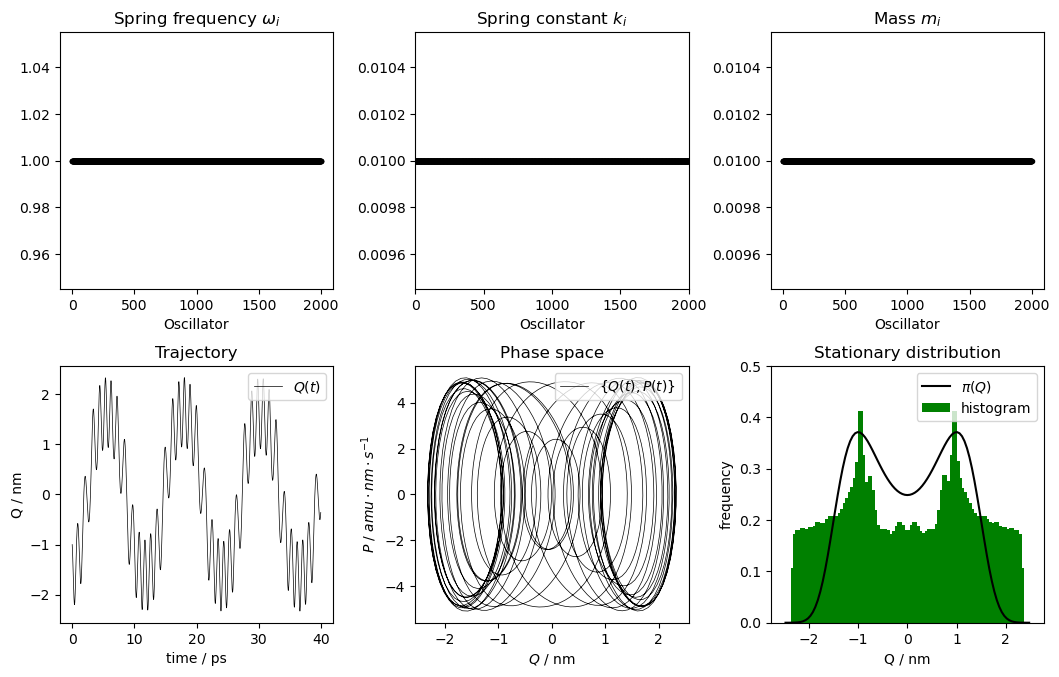

In [51]:
tvalues = np.linspace(0, Nsteps-1,Nsteps) * dt

fig, ax = plt.subplots(2, 3,figsize=(25*in2cm, 15*in2cm))  

####################################################################################################

ax[0,0].plot(omega1, 'k.', linewidth = 1)
ax[0,0].set_xlabel('Oscillator')
ax[0,0].set_title(r'Spring frequency $\omega_i$')

ax[0,1].plot(k_spring1, 'k.', linewidth = 1)
ax[0,1].set_xlabel('Oscillator')
ax[0,1].set_title(r'Spring constant $k_i$')

ax[0,2].plot(m1, 'k.')
ax[0,2].set_xlabel('Oscillator')
ax[0,2].set_title(r'Mass $m_i$')


####################################################################################################

ax[1,0].plot(tvalues[0:int(Nsteps/2000)], Q1[0:int(Nsteps/2000)],'k-', linewidth = 0.5, label = r'$Q(t)$')
ax[1,0].set_xlabel('time / ps')
ax[1,0].set_ylabel('Q / nm')
ax[1,0].set_title('Trajectory')

ax[1,1].plot(Q1[0:int(Nsteps/2000)], P1[0:int(Nsteps/2000)], 'k-', linewidth = 0.5, label = r'$\lbrace Q(t), P(t)\rbrace$')
ax[1,1].set_xlabel(r'$Q$ / nm')
ax[1,1].set_ylabel(r'$P$ / $amu\cdot nm \cdot s^{-1}$')
ax[1,1].set_title('Phase space')

ax[1,2].plot(xcenters, stat_distr, 'k', label = r'$\pi(Q)$')
ax[1,2].bar(xcenters, h1, color='g', width=0.1,  label='histogram')
ax[1,2].set_xlabel('Q / nm')
ax[1,2].set_ylabel('frequency')
ax[1,2].set_title('Stationary distribution')

ax[1,0].legend(loc='upper right')
ax[1,1].legend(loc='upper right')
ax[1,2].legend(loc='upper right')

ax[0,1].set_xlim((0, N))
ax[0,1].set_xlim((0, N))
ax[0,1].set_xlim((0, N))

ax[1,2].set_ylim((0, 0.5))


plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.3)
#fig.savefig('figures/ic1.png', format='png', dpi=900, bbox_inches='tight')

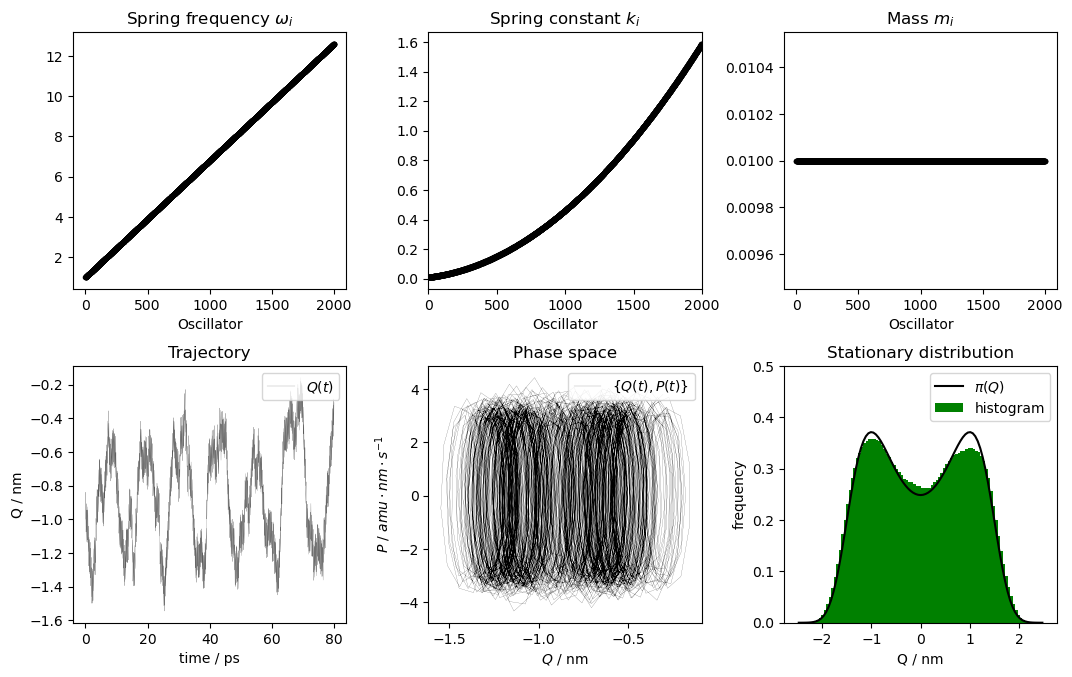

In [52]:
tvalues = np.linspace(0, Nsteps-1,Nsteps) * dt

fig, ax = plt.subplots(2, 3,figsize=(25*in2cm, 15*in2cm))  

####################################################################################################

ax[0,0].plot(omega2, 'k.', linewidth = 1)
ax[0,0].set_xlabel('Oscillator')
ax[0,0].set_title(r'Spring frequency $\omega_i$')

ax[0,1].plot(k_spring2, 'k.', linewidth = 1)
ax[0,1].set_xlabel('Oscillator')
ax[0,1].set_title(r'Spring constant $k_i$')

ax[0,2].plot(m2, 'k.')
ax[0,2].set_xlabel('Oscillator')
ax[0,2].set_title(r'Mass $m_i$')


####################################################################################################

ax[1,0].plot(tvalues[0:int(Nsteps/1000)], Q2[0:int(Nsteps/1000)],'k-', linewidth = 0.1, label = r'$Q(t)$')
ax[1,0].set_xlabel('time / ps')
ax[1,0].set_ylabel('Q / nm')
ax[1,0].set_title('Trajectory')

ax[1,1].plot(Q2[0:int(Nsteps/1000)], P2[0:int(Nsteps/1000)], 'k-', linewidth = 0.1, label = r'$\lbrace Q(t), P(t)\rbrace$')
ax[1,1].set_xlabel(r'$Q$ / nm')
ax[1,1].set_ylabel(r'$P$ / $amu\cdot nm \cdot s^{-1}$')
ax[1,1].set_title('Phase space')

ax[1,2].plot(xcenters, stat_distr, 'k', label = r'$\pi(Q)$')
ax[1,2].bar(xcenters, h2, color='g', width=0.1,  label='histogram')
ax[1,2].set_xlabel('Q / nm')
ax[1,2].set_ylabel('frequency')
ax[1,2].set_title('Stationary distribution')

ax[1,0].legend(loc='upper right')
ax[1,1].legend(loc='upper right')
ax[1,2].legend(loc='upper right')

ax[0,1].set_xlim((0, N))
ax[0,1].set_xlim((0, N))
ax[0,1].set_xlim((0, N))

ax[1,2].set_ylim((0, 0.5))


plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.3)
fig.savefig('figures/ic2.png', format='png', dpi=900, bbox_inches='tight')

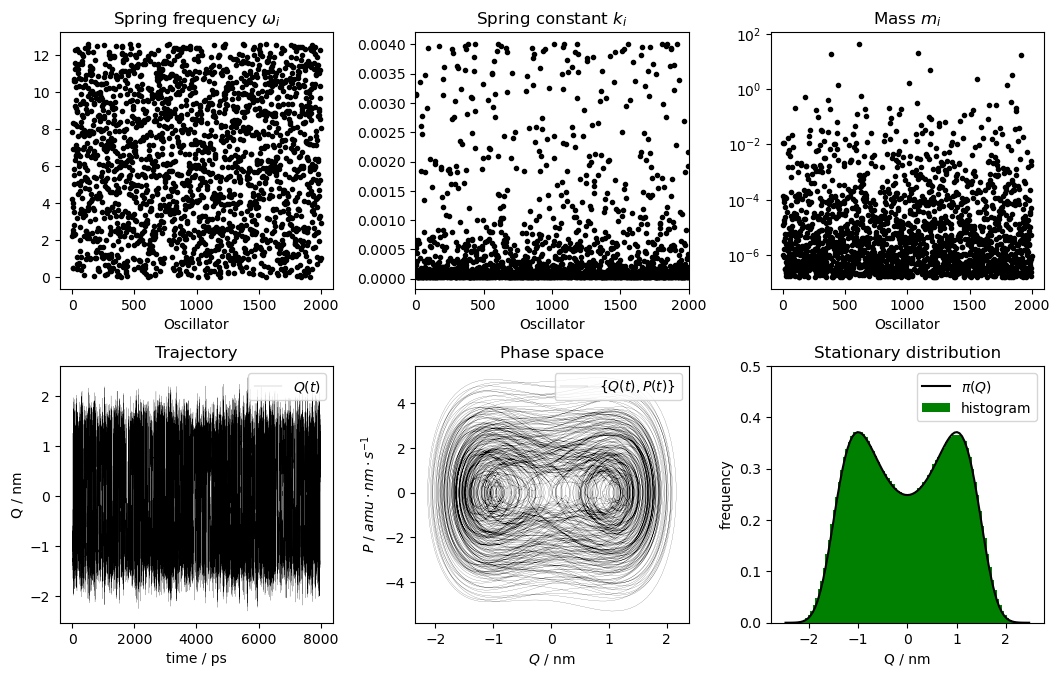

In [47]:
tvalues = np.linspace(0, Nsteps-1,Nsteps) * dt

fig, ax = plt.subplots(2, 3,figsize=(25*in2cm, 15*in2cm))  

####################################################################################################

ax[0,0].plot(omega3, 'k.', linewidth = 1)
ax[0,0].set_xlabel('Oscillator')
ax[0,0].set_title(r'Spring frequency $\omega_i$')

ax[0,1].plot(k_spring3, 'k.', linewidth = 1)
ax[0,1].set_xlabel('Oscillator')
ax[0,1].set_title(r'Spring constant $k_i$')

ax[0,2].plot(m3, 'k.')
ax[0,2].set_xlabel('Oscillator')
ax[0,2].set_title(r'Mass $m_i$')
ax[0,2].set_yscale('log')

####################################################################################################

ax[1,0].plot(tvalues[0:int(Nsteps/10)], Q3[0:int(Nsteps/10)],'k-', linewidth = 0.1, label = r'$Q(t)$')
ax[1,0].set_xlabel('time / ps')
ax[1,0].set_ylabel('Q / nm')
ax[1,0].set_title('Trajectory')

ax[1,1].plot(Q3[0:int(Nsteps/100)], P3[0:int(Nsteps/100)], 'k-', linewidth = 0.1, label = r'$\lbrace Q(t), P(t)\rbrace$')
ax[1,1].set_xlabel(r'$Q$ / nm')
ax[1,1].set_ylabel(r'$P$ / $amu\cdot nm \cdot s^{-1}$')
ax[1,1].set_title('Phase space')

ax[1,2].plot(xcenters, stat_distr, 'k', label = r'$\pi(Q)$')
ax[1,2].bar(xcenters, h3, color='g', width=0.1,  label='histogram')
ax[1,2].set_xlabel('Q / nm')
ax[1,2].set_ylabel('frequency')
ax[1,2].set_title('Stationary distribution')


ax[1,0].legend(loc='upper right')
ax[1,1].legend(loc='upper right')
ax[1,2].legend(loc='upper right')

ax[0,1].set_xlim((0, N))
ax[0,1].set_xlim((0, N))
ax[0,1].set_xlim((0, N))

ax[1,2].set_ylim((0, 0.5))


plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.3)
#fig.savefig('figures/ic3.png', format='png', dpi=900, bbox_inches='tight')

In [ ]:
Q0   = 0

Ns = int(Nsteps/100)
#K = 1/barbeta * np.exp(-alpha*tvalues2)

K1 = np.zeros(Ns)
K2 = np.zeros(Ns)
K3 = np.zeros(Ns)

for k,t in tqdm(enumerate(tvalues[0:Ns])):
    K1[k]  =  np.sum( k_spring1 * np.cos( omega1 * t )  )
    K2[k]  =  np.sum( k_spring2 * np.cos( omega2 * t )  )
    K3[k]  =  np.sum( k_spring3 * np.cos( omega3 * t )  )
    
    

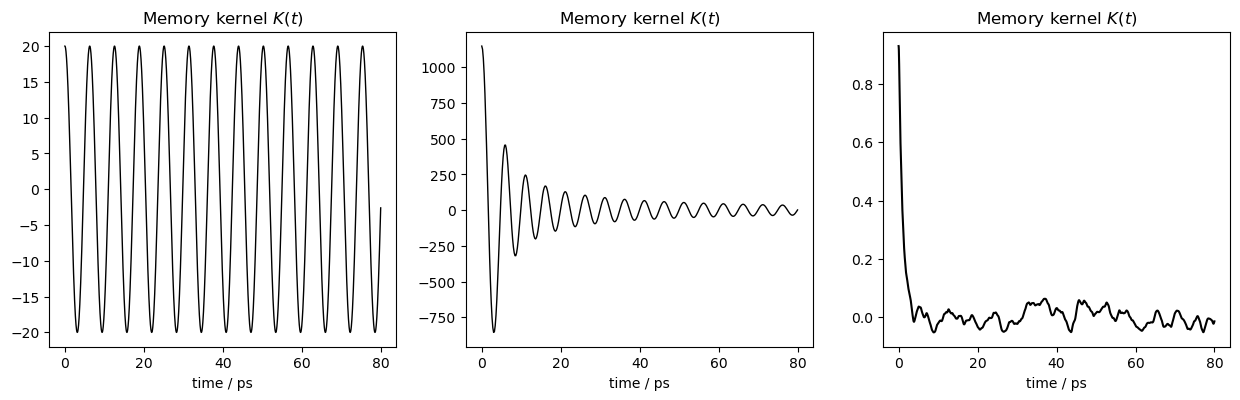

In [42]:
fig, ax = plt.subplots(1, 3,figsize=(30*in2cm, 8*in2cm))  

####################################################################################################

ax[0].plot(tvalues[0:int(Nsteps/1000)], K1[0:int(Nsteps/1000)], 'k', linewidth = 1)
ax[0].set_xlabel('time / ps')
ax[0].set_title(r'Memory kernel $K(t)$')

ax[1].plot(10*tvalues[0:int(Nsteps/10000)], K2[0:int(Nsteps/10000)], 'k', linewidth = 1)
ax[1].set_xlabel('time / ps')
ax[1].set_title(r'Memory kernel $K(t)$')

ax[2].plot(tvalues[0:int(Nsteps/1000)], K3[0:int(Nsteps/1000)], 'k')
ax[2].set_xlabel('time / ps')
ax[2].set_title(r'Memory kernel $K(t)$')

####################################################################################################

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.3)
#fig.savefig('figures/kernel123.png', format='png', dpi=900, bbox_inches='tight')